# Imports

In [32]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
import json
import time

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import backend as K
print('keras version ', keras.__version__)

from IPython.display import clear_output    

keras version  2.4.3


**Mount google drive**

In [33]:
from google.colab import drive
drive.mount('/content/drive')
clear_output(wait=True)
print('finished')

finished


# **SisFall Orginal**

use this block for load orginal data set:

In [ ]:
!mkdir -p dataset/sisfall
!unzip /content/drive/My\ Drive/FallDetection/xvalue_orginal.zip  -d ./dataset/sisfall/
clear_output(wait=True)
print('finished')

finished


In [ ]:
xvalue_path = '/content/dataset/sisfall/xvalue_orginal.npy' 
yvalue_path = '/content/dataset/sisfall/yvalue_orginal.csv'

# **SisFall Smoothed**

use this block for load smoothed dataset:

In [34]:
!mkdir -p dataset/sisfall
!wget https://www.dropbox.com/s/vvxd7whyn76oiua/xvalue.zip  -O ./dataset/sisfall/xvalue.zip 
!unzip ./dataset/sisfall/xvalue.zip   -d ./dataset/sisfall/
!rm ./dataset/sisfall/xvalue.zip
clear_output(wait=True)
print('finished')

finished


In [35]:
xvalue_path = '/content/dataset/sisfall/xvalue.npy' 
yvalue_path = '/content/dataset/sisfall/yvalue.csv'

# Functions

In [36]:
LABELS = ["Bkg","Alert","Fall"]

In [37]:
def show_confusion_matrix(validations, predictions,percent = 0):    
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    if(percent == 1):
        matrix = np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100          
        sns.heatmap(matrix,cmap="coolwarm",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=".2f")    
    else:
        sns.heatmap(matrix,cmap="coolwarm",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=".2f")    
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [38]:
xvalue = np.load(xvalue_path)
yvalue = pd.read_csv( yvalue_path)

print(f'shape xvalue : {xvalue.shape}')
print(f'shape yvalue : {yvalue.shape}')
yvalue.head(1)

shape xvalue : (116988, 256, 9)
shape yvalue : (116988, 3)


,Target,subId,activiteId
0,0,SA01,D01


In [39]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot') # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

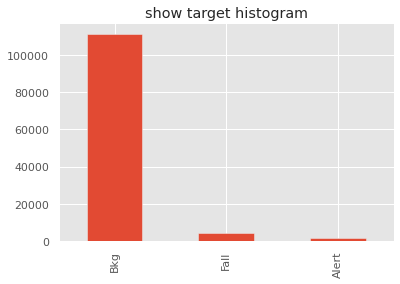

In [40]:
ax = yvalue['Target'].value_counts().plot(kind='bar',title='show target histogram')
ax.set_xticks(range(0,3))
ax.set_xticklabels(['Bkg','Fall','Alert'])
plt.show()

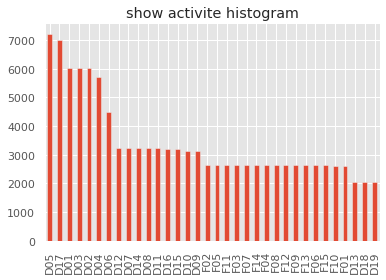

In [41]:
ax = yvalue['activiteId'].value_counts().plot(kind='bar',title='show activite histogram')
plt.show()

In [42]:
yvalue = yvalue['Target']
yvalue.head(1)

0    0
Name: Target, dtype: int64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(xvalue, yvalue, test_size = 0.20, random_state = 0)
print(f'Shape of train feature is : {X_train.shape}')
print(f'Shape of train target is : {y_train.shape}')
print(f'Shape of test feature is : {X_test.shape}')
print(f'Shape of test target is : {y_test.shape}')

Shape of train feature is : (93590, 256, 9)
Shape of train target is : (93590,)
Shape of test feature is : (23398, 256, 9)
Shape of test target is : (23398,)


## reshape

In [44]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = len(LABELS)
print('num_classes: ' + str(num_classes))
print('num_sensors: '+  str(num_sensors))
print('num_time_periods: ' + str(num_time_periods))

num_classes: 3
num_sensors: 9
num_time_periods: 256


### **Run this block only for CNN :**

In [45]:
## only use for cnn 
input_shape = (num_time_periods * num_sensors)
X_train = X_train.reshape(X_train.shape[0], input_shape)
X_test = X_test.reshape(X_test.shape[0], input_shape)
print(X_train.shape)
print(X_test.shape)

(93590, 2304)
(23398, 2304)


##  Convert type for Keras otherwise Keras cannot process the data

In [46]:
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

## Convert lable to one-hot

In [47]:
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_train[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

## **Define our metrics:**

In [49]:
def recall(y_true, y_pred):    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall   
    
def precision(y_true, y_pred):        
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f_score(y_true, y_pred):
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    return 2*((_precision*_recall)/(_precision+_recall+K.epsilon()))

def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n
    
def TP_bkg(y_true, y_pred):
    return TP(y_true[0], y_pred[0])
def TP_alert(y_true, y_pred):
    return TP(y_true[1], y_pred[1])
def TP_fall(y_true, y_pred):
    return TP(y_true[2], y_pred[2])

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def TN_bkg(y_true, y_pred):
    return TN(y_true[0], y_pred[0])
def TN_alert(y_true, y_pred):
    return TN(y_true[1], y_pred[1])
def TN_fall(y_true, y_pred):
    return TN(y_true[2], y_pred[2])
  
def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n
def FP_bkg(y_true, y_pred):
    return FP(y_true[0], y_pred[0])
def FP_alert(y_true, y_pred):
    return FP(y_true[1], y_pred[1])
def FP_fall(y_true, y_pred):
    return FP(y_true[2], y_pred[2])

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN
    return tn/n

def FN_bkg(y_true, y_pred):
    return FN(y_true[0], y_pred[0])

def FN_alert(y_true, y_pred):
    return FN(y_true[1], y_pred[1])
    
def FN_fall(y_true, y_pred):
    return FN(y_true[2], y_pred[2])

class_weight = {0: 1.,
                1: sum(y_train[:,0]) / sum(y_train[:,1]),
                2: sum(y_train[:,0]) / sum(y_train[:,2])}

In [50]:
_metrics = ['acc',
         f_score,
         TP_bkg,TN_bkg,FP_bkg,FN_bkg,
         TP_alert,TN_alert,FP_alert,FN_alert,
         TP_fall,TN_fall,FP_fall,FN_fall]

In [51]:
# normalize class weights
s = class_weight[0] + class_weight[1] + class_weight[2]
class_weight[0] /= s
class_weight[1] /= s
class_weight[2] /= s
class_weight

{0: 0.009089563595248441, 1: 0.7433530088532095, 2: 0.247557427551542}

# **CNN**


## Build our model

In [52]:
model_m = Sequential()
model_m.add(Reshape((num_time_periods, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(num_time_periods, num_sensors)))
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(1920, activation='relu'))
model_m.add(Dense(512, activation='relu'))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 256, 9)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 254, 64)           1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 254, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 82, 64)            12352     
_________________________________________________________________
batch_normalization_4 (Batch (None, 82, 64)            256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27, 64)           

## Fit CNN the model

In [53]:
start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='./drive/My Drive/FallDetection/CNN_Model.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True)]
                                                  #keras.callbacks.EarlyStopping(monitor='acc', patience=1)]


# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
#                                                           decay_steps=10000,
#                                                           decay_rate=0.9)

optimizer = keras.optimizers.Adam(clipvalue=0.5)

model_m.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics = _metrics) #loss=weighted_categorical_crossentropy(weights)
                
BATCH_SIZE = 64
EPOCHS = 100

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1,
                      class_weight=class_weight) 

json.dump(history.history, open("./drive/My Drive/FallDetection/CNN_History.pkl", "w"))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
1170/1170 [==============================] - 97s 83ms/step - loss: 0.0181 - acc: 0.7789 - f_score: 0.7791 - TP_bkg: 0.2456 - TN_bkg: 0.6180 - FP_bkg: 0.0487 - FN_bkg: 0.0877 - TP_alert: 0.2464 - TN_alert: 0.6217 - FP_alert: 0.0450 - FN_alert: 0.0869 - TP_fall: 0.2510 - TN_fall: 0.6205 - FP_fall: 0.0462 - FN_fall: 0.0823 - val_loss: 0.3304 - val_acc: 0.8979 - val_f_score: 0.8981 - val_TP_bkg: 0.2799 - val_TN_bkg: 0.6394 - val_FP_bkg: 0.0273 - val_FN_bkg: 0.0535 - val_TP_alert: 0.2856 - val_TN_alert: 0.6451 - val_FP_alert: 0.0216 - val_FN_alert: 0.0478 - val_TP_fall: 0.2924 - val_TN_fall: 0.6439 - val_FP_fall: 0.0228 - val_FN_fall: 0.0410
Epoch 2/100
1170/1170 [==============================] - 96s 82ms/step - loss: 0.0136 - acc: 0.8472 - f_score: 0.8461 - TP_bkg: 0.2775 - TN_bkg: 0.6262 - FP_bkg: 0.0405 - FN_bkg: 0.0558 - TP_alert: 0.2769 - TN_alert: 0.6285 - FP_alert: 0.0382 - FN_alert: 0.0564 - TP_fall: 0.2766 - TN_fall: 0.6251 - FP_fall: 0.0416 - FN_fall: 0.0567 - val_los

# **LSTM**

## Build our model

In [ ]:
model_m = keras.Sequential()
model_m.add(Dense(32, activation='relu', input_shape=(num_time_periods, num_sensors)))
model_m.add(BatchNormalization())
model_m.add(Dropout(0.5))
model_m.add(LSTM(32, activation='relu', return_sequences=True))
model_m.add(Dropout(0.5))
model_m.add(LSTM(32, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(Dense(512))
model_m.add(Dense(num_classes, activation='softmax'))
model_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256, 32)           320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 256, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256, 32)           8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

## Fit LSTM the model

In [ ]:
start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='./drive/My Drive/FallDetection/LSTM_Model.h5',
                                                  monitor='val_loss', save_best_only=True)]#keras.callbacks.EarlyStopping(monitor='acc', patience=1)]

optimizer = keras.optimizers.Adam(clipvalue=0.5)
model_m.compile(loss='categorical_crossentropy',
                optimizer=optimizer, 
                metrics=_metrics)

BATCH_SIZE = 64
EPOCHS = 40

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1,
                      class_weight=class_weight)

json.dump(history.history, open("./drive/My Drive/FallDetection/LSTM_History.pkl", "w"))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/40
1170/1170 [==============================] - 338s 289ms/step - loss: 167784924642803712.0000 - acc: 0.2187 - f_score: 0.2044 - TP_bkg: 0.0678 - TN_bkg: 0.5513 - FP_bkg: 0.1154 - FN_bkg: 0.2655 - TP_alert: 0.0570 - TN_alert: 0.5422 - FP_alert: 0.1245 - FN_alert: 0.2764 - TP_fall: 0.0530 - TN_fall: 0.5399 - FP_fall: 0.1268 - FN_fall: 0.2803 - val_loss: 238.6214 - val_acc: 0.0459 - val_f_score: 0.0339 - val_TP_bkg: 0.0068 - val_TN_bkg: 0.6519 - val_FP_bkg: 0.0148 - val_FN_bkg: 0.3265 - val_TP_alert: 0.0114 - val_TN_alert: 0.6507 - val_FP_alert: 0.0159 - val_FN_alert: 0.3220 - val_TP_fall: 0.0034 - val_TN_fall: 0.6564 - val_FP_fall: 0.0102 - val_FN_fall: 0.3299
Epoch 2/40
1170/1170 [==============================] - 334s 285ms/step - loss: 0.0321 - acc: 0.2154 - f_score: 0.0226 - TP_bkg: 0.0037 - TN_bkg: 0.6601 - FP_bkg: 0.0066 - FN_bkg: 0.3296 - TP_alert: 0.0048 - TN_alert: 0.6613 - FP_alert: 0.0054 - FN_alert: 0.3285 - TP_fall: 0.0040 - TN_fall: 0.6630 - FP_fall: 0.0037 - FN_f

# **ConvLSTM**

In [ ]:
model_m = keras.Sequential()
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(num_time_periods, num_sensors)))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(LSTM(32, activation='relu', return_sequences=True))
model_m.add(Dropout(0.5))
model_m.add(LSTM(32, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(Dense(512))
model_m.add(Dense(num_classes, activation='softmax'))
model_m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 254, 64)           1792      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 127, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 125, 64)           12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 64)            12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 28, 64)           

In [ ]:
start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='./drive/My Drive/FallDetection/ConvLSTM_Model.h5',
                                                  monitor='val_loss', save_best_only=True)]#keras.callbacks.EarlyStopping(monitor='acc', patience=1)]

optimizer = keras.optimizers.Adam(clipvalue=0.5)
model_m.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=_metrics)

BATCH_SIZE = 64
EPOCHS = 100

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1,
                      class_weight=class_weight)

json.dump(history.history, open("./drive/My Drive/FallDetection/ConvLSTM_History.pkl", "w"))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
1170/1170 [==============================] - 126s 108ms/step - loss: 0.0180 - acc: 0.8462 - f_score: 0.8120 - TP_bkg: 0.2564 - TN_bkg: 0.6407 - FP_bkg: 0.0259 - FN_bkg: 0.0769 - TP_alert: 0.2547 - TN_alert: 0.6462 - FP_alert: 0.0205 - FN_alert: 0.0786 - TP_fall: 0.2550 - TN_fall: 0.6419 - FP_fall: 0.0248 - FN_fall: 0.0783 - val_loss: 0.4982 - val_acc: 0.8590 - val_f_score: 0.8642 - val_TP_bkg: 0.2628 - val_TN_bkg: 0.6451 - val_FP_bkg: 0.0216 - val_FN_bkg: 0.0705 - val_TP_alert: 0.2662 - val_TN_alert: 0.6473 - val_FP_alert: 0.0193 - val_FN_alert: 0.0671 - val_TP_fall: 0.2730 - val_TN_fall: 0.6428 - val_FP_fall: 0.0239 - val_FN_fall: 0.0603
Epoch 2/100
1170/1170 [==============================] - 124s 106ms/step - loss: 0.0130 - acc: 0.8861 - f_score: 0.8870 - TP_bkg: 0.2912 - TN_bkg: 0.6390 - FP_bkg: 0.0276 - FN_bkg: 0.0422 - TP_alert: 0.2883 - TN_alert: 0.6419 - FP_alert: 0.0248 - FN_alert: 0.0450 - TP_fall: 0.2897 - TN_fall: 0.6442 - FP_fall: 0.0225 - FN_fall: 0.0436 - val

# **Show result**

In [54]:
structure = "CNN"
#structure = "LSTM"
#structure = "ConvLSTM"

In [55]:
model_m = keras.models.load_model(f"./drive/My Drive/FallDetection/{structure}_Model.h5",
                                  custom_objects={"f_score":f_score,"TP_bkg":TP_bkg,"TN_bkg":TN_bkg,
                                  "FP_bkg":FP_bkg,"FN_bkg":FN_bkg,"TP_alert":TP_alert,
                                  "TN_alert":TN_alert,"FP_alert":FP_alert,"FN_alert":FN_alert,
                                  "TP_fall":TP_fall,"TN_fall":TN_fall,"FP_fall":FP_fall,"FN_fall":FN_fall})

In [56]:
history_dict = json.load(open(f"./drive/My Drive/FallDetection/{structure}_History.pkl", 'r'))

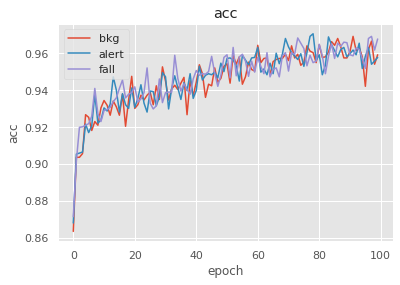

In [57]:
def accurace(tp,tn,fp,fn):
  return (np.array(tp)+ np.array(tn)) / (np.array(tp)+np.array(tn)+np.array(fn)+np.array(fp))
acc_bkg = accurace(history_dict['TP_bkg'] ,history_dict['TN_bkg'] ,history_dict['FP_bkg'] ,history_dict['FN_bkg'] )
acc_alert = accurace(history_dict['TP_alert'] ,history_dict['TN_alert'] ,history_dict['FP_alert'] ,history_dict['FN_alert'])
acc_fall = accurace(history_dict['TP_fall'] ,history_dict['TN_fall'] ,history_dict['FP_fall'] ,history_dict['FN_fall'] )
plt.plot(acc_bkg)
plt.plot(acc_alert)
plt.plot(acc_fall)
plt.title('acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['bkg', 'alert','fall'], loc='upper left')
plt.show()

sensivity bkg : 93.67523969481739
sensivity alert : 93.58977020395666
sensivity fall : 94.95728955074705
avg of sensivity : 94.07409981650703


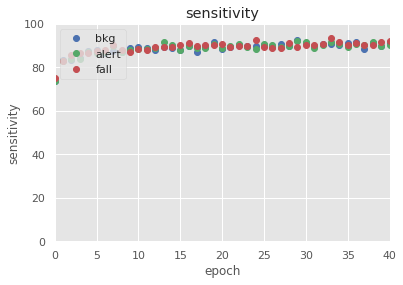

In [58]:
def sensitivity(tp,tn,fp,fn):
  return np.array(tp) / (np.array(tp)+np.array(fn)) * 100
sen_bkg = sensitivity(history_dict['TP_bkg'] ,history_dict['TN_bkg'] ,history_dict['FP_bkg'] ,history_dict['FN_bkg'] )
print(f'sensivity bkg : {sen_bkg[-1]}')
sen_alert = sensitivity(history_dict['TP_alert'] ,history_dict['TN_alert'] ,history_dict['FP_alert'] ,history_dict['FN_alert'])
print(f'sensivity alert : {sen_alert[-1]}')
sen_fall = sensitivity(history_dict['TP_fall'] ,history_dict['TN_fall'] ,history_dict['FP_fall'] ,history_dict['FN_fall'] )
print(f'sensivity fall : {sen_fall[-1]}')
print(f'avg of sensivity : {(sen_bkg[-1] + sen_alert[-1]+ sen_fall[-1])/3}')
plt.plot(sen_bkg,'bo')
plt.plot(sen_alert,'go')
plt.plot(sen_fall,'ro')
plt.title('sensitivity')
plt.ylabel('sensitivity')
plt.xlabel('epoch')
plt.legend(['bkg', 'alert','fall'], loc='upper left')
plt.axis([0, 40, 0, 100])
plt.show()

specificity bkg : 93.67523969481739
specificity alert : 93.58977020395666
specificity fall : 94.95728955074705
avg of specificity : 97.20799079801479


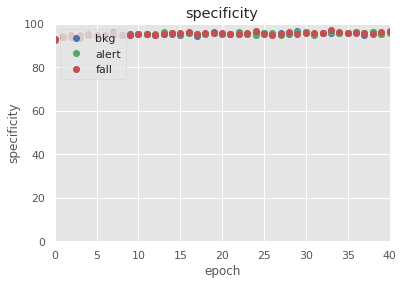

In [59]:
def specificity(tp,tn,fp,fn):
  return np.array(tn) / (np.array(tn)+np.array(fp)) * 100
sep_bkg = specificity(history_dict['TP_bkg'] ,history_dict['TN_bkg'] ,history_dict['FP_bkg'] ,history_dict['FN_bkg'] )
print(f'specificity bkg : {sen_bkg[-1]}')
sep_alert = specificity(history_dict['TP_alert'] ,history_dict['TN_alert'] ,history_dict['FP_alert'] ,history_dict['FN_alert'])
print(f'specificity alert : {sen_alert[-1]}')
sep_fall = specificity(history_dict['TP_fall'] ,history_dict['TN_fall'] ,history_dict['FP_fall'] ,history_dict['FN_fall'] )
print(f'specificity fall : {sen_fall[-1]}')
print(f'avg of specificity : {(sep_bkg[-1] + sep_alert[-1]+ sep_fall[-1])/3}')
plt.plot(sep_bkg,'bo')
plt.plot(sep_alert,'go')
plt.plot(sep_fall,'ro')
plt.title('specificity')
plt.ylabel('specificity')
plt.xlabel('epoch')
plt.legend(['bkg', 'alert','fall'], loc='upper left')
plt.axis([0, 40, 0, 100])
plt.show()

In [60]:
prep = model_m.predict(X_test)
prep2 = prep.copy()

In [61]:
prep3 = [i == max(i) for i in prep2]
p = [i[0] for i in prep3]
t = [i[0]==1 for i in y_test]
bkgacc = (sum([p[i] == t[i] for i in range(0,len(p))]) / len(p)) * 100
p = [i[1] for i in prep3]
t = [i[1]==1 for i in y_test]
alartacc = (sum([p[i] == t[i] for i in range(0,len(p))]) / len(p)) * 100
p = [i[2] for i in prep3]
t = [i[2]==1 for i in y_test]
fallacc = (sum([p[i] == t[i] for i in range(0,len(p))]) / len(p)) * 100
print(f'bkg acc: {bkgacc}')
print(f'alart acc: {alartacc}')
print(f'fall acc: {fallacc}')
print(f'mean: {(bkgacc + alartacc + fallacc)/3}')

bkg acc: 95.02521583041286
alart acc: 96.16633900333362
fall acc: 98.30327378408411
mean: 96.49827620594353


In [62]:
score = model_m.evaluate(X_test, y_test, verbose=2,batch_size=64)

print("\nAccuracy on test data: %0.4f" % (score[1]*100))
print("\nLoss on test data: %0.4f" % score[0])

366/366 - 5s - loss: 0.1716 - acc: 0.9475 - f_score: 0.9476 - TP_bkg: 0.3188 - TN_bkg: 0.6521 - FP_bkg: 0.0146 - FN_bkg: 0.0146 - TP_alert: 0.3142 - TN_alert: 0.6485 - FP_alert: 0.0182 - FN_alert: 0.0191 - TP_fall: 0.3160 - TN_fall: 0.6494 - FP_fall: 0.0173 - FN_fall: 0.0173

Accuracy on test data: 94.7474

Loss on test data: 0.1716



--- Confusion matrix for test data ---



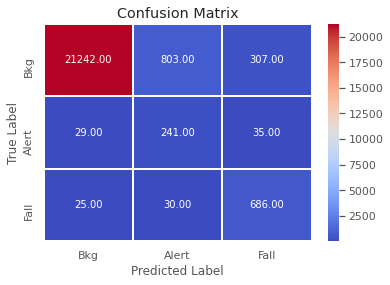

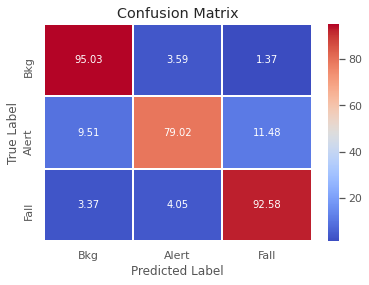

In [63]:
print("\n--- Confusion matrix for test data ---\n")
y_pred_test = model_m.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test,0)
show_confusion_matrix(max_y_test, max_y_pred_test,1)